In [18]:
import os, pathlib, sys, platform

PROJECT_DIR = pathlib.Path.cwd() / "softlight_agent_b_notebook"
PROJECT_DIR.mkdir(exist_ok=True)
RUNS_DIR = PROJECT_DIR / "runs"
RUNS_DIR.mkdir(exist_ok=True)

PROJECT_DIR, RUNS_DIR


(PosixPath('/Users/anshulsingh/softlight_agent_b_notebook/softlight_agent_b_notebook'),
 PosixPath('/Users/anshulsingh/softlight_agent_b_notebook/softlight_agent_b_notebook/runs'))

In [19]:
!pip install -q playwright==1.48.0 python-slugify==8.0.4 beautifulsoup4==4.12.3 lxml==5.3.0 rapidfuzz==3.9.6 orjson==3.10.7
!python -m playwright install


In [20]:
TASKS = [
    {
        "name": "Linear – Create Project",
        "app": "linear",
        "start_url": "https://linear.app/",
        "instruction": (
            'Create a new project called "Quarterly Growth" in the Softlight team. '
            'Set status to "Planned" and add a short description.'
        ),
        "notes": [
            'Prefer top-nav "Projects" then a primary "Create project" action.',
            "Capture the create dialog, form filling, and success/toast state."
        ],
    },
    {
        "name": "Linear – Filter Issues by Status",
        "app": "linear",
        "start_url": "https://linear.app/",
        "instruction": (
            'Open the issues list and add a filter where Status is "Open".'
        ),
        "notes": [
            "Capture filter popover and the updated list state."
        ],
    },
    {
        "name": "Notion – Create a Database Page",
        "app": "notion",
        "start_url": "https://www.notion.so/",
        "instruction": (
            'Create a new database page named "Bugs".'
        ),
        "notes": [
            "Capture any modal or inline builder and the new table view."
        ],
    },
    {
        "name": "Notion – Add Filter to Database",
        "app": "notion",
        "start_url": "https://www.notion.so/",
        "instruction": (
            'Open the "Bugs" database and add a filter where Status is "Open".'
        ),
        "notes": [
            "Capture the filter popover and resulting filtered table."
        ],
    },
]
len(TASKS)


4

In [21]:
# One-shot async agent for Jupyter (all definitions in one cell)

import re, pathlib, hashlib, orjson
from dataclasses import dataclass
from typing import Optional, List
from slugify import slugify
from datetime import datetime
from rapidfuzz import process
from playwright.async_api import async_playwright, TimeoutError as PWTimeout

# ---------- Planner ----------
@dataclass
class Action:
    kind: str        # NAVIGATE, OPEN, CLICK, TYPE, SELECT, WAIT_FOR
    target: str
    by: Optional[str] = None
    value: Optional[str] = None

def plan_actions(instruction: str, notes: List[str]) -> List[Action]:
    text = instruction.lower()
    if "create" in text and "project" in text:
        return [
            Action('NAVIGATE', 'Projects'),
            Action('CLICK', 'Create project'),
            Action('TYPE', 'Name', by='label'),
            Action('TYPE', 'Description', by='label'),
            Action('SELECT', 'Status', by='label'),
            Action('CLICK', 'Create'),
            Action('WAIT_FOR', 'toast'),
        ]
    if "filter" in text and ("issues" in text or "database" in text):
        return [
            Action('OPEN', 'Filter'),
            Action('SELECT', 'Property', by='label'),
            Action('SELECT', 'Condition', by='label'),
            Action('SELECT', 'Value', by='label'),
            Action('WAIT_FOR', 'table-updated'),
        ]
    return [Action('CLICK','New'), Action('WAIT_FOR','dialog')]

# ---------- Capture ----------
class CaptureManagerA:
    def __init__(self, page, out_dir: pathlib.Path):
        self.page = page
        self.out_dir = out_dir
        self.step = 0
        out_dir.mkdir(parents=True, exist_ok=True)

    async def capture(self, label="state"):
        self.step += 1
        sd = self.out_dir / f"step_{self.step:02d}_{self._slug(label)}"
        sd.mkdir(parents=True, exist_ok=True)
        try:
            await self.page.screenshot(path=str(sd/"screenshot.png"), full_page=True)
        except Exception:
            pass
        (sd/"url.txt").write_text(self.page.url or "")
        try:
            html = await self.page.content()
            (sd/"dom.html").write_text(html)
        except Exception:
            pass
        try:
            a11y = await self.page.accessibility.snapshot()
            (sd/"a11y.json").write_bytes(orjson.dumps(a11y))
        except Exception:
            pass
        try:
            sig = hashlib.sha1((self.page.url or "").encode()).write
        except Exception:
            pass

    @staticmethod
    def _slug(s: str) -> str:
        return "".join(c.lower() if c.isalnum() else "-" for c in s)[:40].strip("-")

# ---------- Locators ----------
ROLE_CANDIDATES = ['button','link','menuitem','textbox','combobox','listbox','dialog','option','tab','checkbox','radio']

class LocatorResolverA:
    def __init__(self, page):
        self.page = page

    async def by_semantics(self, name: str):
        name = str(name).strip()
        for role in ROLE_CANDIDATES:
            try:
                loc = self.page.get_by_role(role, name=re.compile(re.escape(name), re.I))
                if await loc.count() > 0:
                    return loc.first
            except Exception:
                pass
        try:
            loc = self.page.get_by_label(re.compile(re.escape(name), re.I))
            if await loc.count() > 0:
                return loc.first
        except Exception:
            pass
        try:
            loc = self.page.get_by_text(re.compile(re.escape(name), re.I))
            if await loc.count() > 0:
                return loc.first
        except Exception:
            pass
        try:
            loc = self.page.locator(f"[data-testid*='{name}']")
            if await loc.count() > 0:
                return loc.first
        except Exception:
            pass
        try:
            all_nodes = self.page.locator("body *:visible")
            texts = await all_nodes.all_text_contents()
            if texts:
                best = process.extractOne(name, texts)
                if best and best[1] > 70:
                    return self.page.get_by_text(re.compile(re.escape(best[0]), re.I)).first
        except Exception:
            pass
        return None

# ---------- Detectors ----------
class CompositeDetectorsA:
    def __init__(self, page, cap: CaptureManagerA):
        self.page = page
        self.cap = cap
        self._sig = None

    async def after_action(self, label_hint=""):
        await self.page.wait_for_timeout(300)
        captured = False
        if await self._has_dialog():
            await self.cap.capture(label_hint or "dialog-open")
            captured = True
        if await self._has_toast():
            await self.cap.capture("toast")
            captured = True
        if await self._content_changed():
            await self.cap.capture(label_hint or "content-change")
            captured = True
        return captured

    async def _has_dialog(self):
        try:
            d = self.page.get_by_role('dialog')
            return (await d.count()) > 0 and await d.first.is_visible()
        except Exception:
            return False

    async def _has_toast(self):
        try:
            a = self.page.get_by_role('alert')
            if (await a.count()) > 0 and await a.first.is_visible():
                return True
            live = self.page.locator("[aria-live]:visible")
            return (await live.count()) > 0
        except Exception:
            return False

    async def _content_changed(self):
        try:
            body = self.page.locator("body")
            txt = (await body.inner_text())[:5000]
            new_sig = hashlib.sha1(txt.encode("utf-8","ignore")).hexdigest()
            old_sig = self._sig
            self._sig = new_sig
            return (old_sig is not None) and (old_sig != new_sig)
        except Exception:
            return False

# ---------- Executor ----------
class ExecutorA:
    def __init__(self, page, cap: CaptureManagerA, det: CompositeDetectorsA, instruction_text: str):
        self.page = page
        self.cap = cap
        self.det = det
        self.loc = LocatorResolverA(page)
        self.instruction_text = instruction_text

    async def run(self, action, step_idx: int):
        k, t = action.kind, action.target
        label = f"{step_idx:02d}-{k.lower()}-{t}"
        if k in ("NAVIGATE","OPEN","CLICK"):
            el = await self.loc.by_semantics(t)
            if el:
                await el.scroll_into_view_if_needed()
                await el.click(timeout=5000)
            await self.det.after_action(k.lower())
            await self.cap.capture(label)
            return
        if k == "TYPE":
            el = await self.loc.by_semantics(action.target)
            if el:
                quoted = re.findall(r'"([^"]+)"', self.instruction_text)
                value = (quoted[0] if quoted else action.value) or action.target
                await el.fill(value)
            await self.det.after_action("type")
            await self.cap.capture(label)
            return
        if k == "SELECT":
            el = await self.loc.by_semantics(action.target)
            if el:
                await el.click()
                quoted = re.findall(r'"([^"]+)"', self.instruction_text)
                choice = (quoted[-1] if quoted else action.value) or "Planned"
                opt = await self.loc.by_semantics(choice)
                if opt:
                    await opt.click()
            await self.det.after_action("select")
            await self.cap.capture(label)
            return
        if k == "WAIT_FOR":
            await self.page.wait_for_timeout(600)
            await self.det.after_action(action.target)
            await self.cap.capture(label)
            return

# ---------- Orchestrator ----------
class OrchestratorAsync:
    def __init__(self, task: dict, runs_root: pathlib.Path, headless=False):
        self.task = task
        self.runs_root = runs_root
        self.headless = headless

    async def run(self):
        app = self.task["app"]
        task_name = slugify(self.task.get("name") or self.task.get("instruction")[:60])
        ts = datetime.now().strftime("%Y%m%d-%H%M%S")
        out_dir = self.runs_root / ts / slugify(app) / task_name
        out_dir.mkdir(parents=True, exist_ok=True)

        async with async_playwright() as p:
            browser = await p.chromium.launch(headless=self.headless, args=["--disable-blink-features=AutomationControlled"])
            ctx = await browser.new_context(ignore_https_errors=True, viewport={"width":1280,"height":800})
            page = await ctx.new_page()

            cap = CaptureManagerA(page, out_dir)
            det = CompositeDetectorsA(page, cap)

            await page.goto(self.task["start_url"], wait_until="domcontentloaded")
            await cap.capture("start")

            actions = plan_actions(self.task["instruction"], self.task.get("notes", []))
            exe = ExecutorA(page, cap, det, instruction_text=self.task["instruction"])

            for i, a in enumerate(actions, 1):
                try:
                    await exe.run(a, i)
                except PWTimeout:
                    await cap.capture(f"timeout-{a.kind}-{a.target}")
                except Exception:
                    await cap.capture(f"error-{a.kind}-{a.target}")

            await cap.capture("final")
            await ctx.storage_state(path=str(out_dir/"storage_state.json"))
            await browser.close()

        return out_dir

print("Defined: Action, plan_actions, CaptureManagerA, LocatorResolverA, CompositeDetectorsA, ExecutorA, OrchestratorAsync")


Defined: Action, plan_actions, CaptureManagerA, LocatorResolverA, CompositeDetectorsA, ExecutorA, OrchestratorAsync


In [22]:
task = TASKS[0]
runner = OrchestratorAsync(task, runs_root=RUNS_DIR, headless=False)
out_dir = await runner.run()
print("Dataset saved to:", out_dir)


Dataset saved to: /Users/anshulsingh/softlight_agent_b_notebook/softlight_agent_b_notebook/runs/20251111-143831/linear/linear-create-project


Last run folder: softlight_agent_b_notebook/runs/20251111-143831/linear/linear-create-project/step_14_final


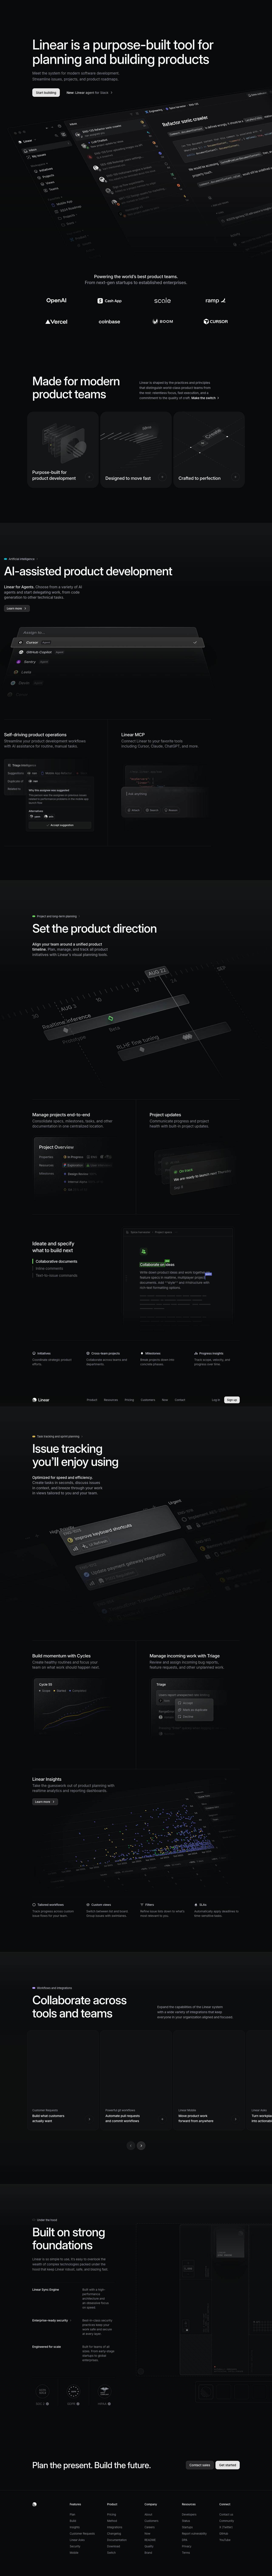

In [23]:
from pathlib import Path
from IPython.display import Image, display

latest_run = sorted(Path("softlight_agent_b_notebook/runs").rglob("screenshot.png"))[-1].parent
print("Last run folder:", latest_run)
display(Image(filename=str(latest_run / "screenshot.png")))


In [25]:
for t in TASKS:
    print("Running:", t["name"])
    out = await OrchestratorAsync(t, runs_root=RUNS_DIR, headless=False).run()
    print(" → saved:", out, "\n")


Running: Linear – Create Project
 → saved: /Users/anshulsingh/softlight_agent_b_notebook/softlight_agent_b_notebook/runs/20251111-144109/linear/linear-create-project 

Running: Linear – Filter Issues by Status
 → saved: /Users/anshulsingh/softlight_agent_b_notebook/softlight_agent_b_notebook/runs/20251111-144134/linear/linear-filter-issues-by-status 

Running: Notion – Create a Database Page
 → saved: /Users/anshulsingh/softlight_agent_b_notebook/softlight_agent_b_notebook/runs/20251111-144217/notion/notion-create-a-database-page 

Running: Notion – Add Filter to Database
 → saved: /Users/anshulsingh/softlight_agent_b_notebook/softlight_agent_b_notebook/runs/20251111-144253/notion/notion-add-filter-to-database 



In [26]:
import os
os.getcwd()

'/Users/anshulsingh/softlight_agent_b_notebook'